In [88]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as datetime

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from raytracer_utils import readdump, read_rayfile, read_rayfiles
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

from mpl_toolkits.axes_grid1 import make_axes_locatable

import xflib
xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/3dWIPP/python/libxformd.so')



# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 4
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

# Volume of voxel:
def voxel_volume(points):
    tri = Delaunay(points.T, qhull_options='QJ')
    v = 0
    for row in tri.simplices:
        a = points[:,row[0]]
        b = points[:,row[1]]
        c = points[:,row[2]]
        d = points[:,row[3]]
        
        v += np.abs( np.dot(a - d, np.cross(b-d, c-d)))/6.
    return v

def rotate_latlon(raypos, itime, dlat, dlon, xf=None):
    if xf is None:
        xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/3dWIPP/python/libxformd.so')
        
    newpos = np.zeros_like(raypos)
    for ind in range(np.shape(raypos)[1]):
#         print ind
        tmp = xf.sm2rllmag(raypos[:,ind], itime)
        tmp[1] += dlat
        tmp[2] += dlon
        newpos[:,ind] = xf.rllmag2sm(tmp, itime)
    
    return newpos






In [94]:

d_lon = 1
num_lons = 10
flash_lons = np.arange(flash_lon, flash_lon + (num_lons +1)*d_lon, d_lon)
print flash_lons

print lon_pairs[0]

[ 76.61840223  77.61840223  78.61840223  79.61840223  80.61840223
  81.61840223  82.61840223  83.61840223  84.61840223  85.61840223
  86.61840223]
(76.1184022256313, 77.1184022256313)


In [89]:
# 2d ray loader (rotate and clone to get longitudes):
# Full 3d-ray loader:
ray_dir = '/shared/users/asousa/WIPP/rays/2d/nightside/gcpm_kp0/'
from raytracer_utils import read_rayfile, read_damp
from scipy.spatial import Delaunay
from scipy import stats


itime = datetime.datetime(2010,1,1,0,0,0)
flash_lat = 40
# flash_lon = 76
sun = xf.gse2sm([-1,0,0], itime)
sun_geomag_midnight = (xf.sm2rllmag(sun, itime))
sun = xf.gse2sm([1,0,0], itime)
sun_geomag_noon = (xf.sm2rllmag(sun, itime))

flash_lon = sun_geomag_midnight[2]
print flash_lat, flash_lon

d_lon = 1
num_lons = 10
flash_lons = np.arange(flash_lon, flash_lon + (num_lons +1)*d_lon, d_lon)



max_dist = 1000 #km
tmax = 20
dt   = 0.1
t = np.arange(0,tmax, dt)
        
R_E = 6371e3;
Hz2Rad = 2.*np.pi
D2R = np.pi/180.
H_IONO = 1e5


d = os.listdir(ray_dir)
freqs = sorted([int(f[2:]) for f in d if f.startswith('f_')])
d = os.listdir(os.path.join(ray_dir, 'f_%d'%freqs[0]))
lons = sorted([float(f[4:]) for f in d if f.startswith('lon_')])
d = os.listdir(os.path.join(ray_dir, 'f_%d'%freqs[0], 'lon_%d'%lons[0]))
lats = sorted([float(s.split('_')[2]) for s in d if s.startswith('ray_')])

# Closest available longitude to the flash:
center_lon = lons[np.argmin(np.abs(np.array(lons) - flash_lon))]
center_lat = lats[np.argmin(np.abs(np.array(lats) - flash_lat))]


# Latitude spacing:
# dl = stats.mode(np.diff(lats))[0][0]
# d_lon = 1

newlons = np.array([flash_lon - d_lon/2., flash_lon + d_lon/2.])
latgrid, longrid = np.meshgrid(lats,newlons)
latln_pairs = zip(latgrid.ravel(), longrid.ravel())

pairs_in_range = []

# Select points within range.
# Prune out some points the further out we go:
for coords in latln_pairs:
    cur_d = haversine_np(flash_lon, flash_lat, coords[1], coords[0])
    if cur_d < max_dist:
        pairs_in_range.append(coords)
            
# print pairs_in_range
    
        
# Load and interpolate the center longitude entries:
center_data = dict()
for freq in freqs:
    print "freq: ", freq
    for lat in np.unique([x[0] for x in pairs_in_range]):
        lon = center_lon
        filename = os.path.join(ray_dir,'f_%d'%freq,'lon_%d'%lon,'ray_%d_%d_%d.ray'%(freq,lat,lon))
#         print filename
        rf = read_rayfile(filename)[0]
        
        filename = os.path.join(ray_dir,'f_%d'%freq,'lon_%d'%lon,'damp_%d_%d_%d.ray'%(freq,lat,lon))
        df = read_damp(filename)[0]
        
        t_cur = t[t <= rf['time'].iloc[-1]]
        
        # Interpolate onto our new time axis:
        x = interpolate.interp1d(rf['time'],rf['pos']['x']).__call__(t_cur)/R_E
        y = interpolate.interp1d(rf['time'],rf['pos']['y']).__call__(t_cur)/R_E
        z = interpolate.interp1d(rf['time'],rf['pos']['z']).__call__(t_cur)/R_E
        d = interpolate.interp1d(df['time'],df['damping']).__call__(t_cur)
        
        # Stash it somewhere:
        key = (freq, lat, lon)
        curdata = dict()
        curdata['pos'] = np.vstack([x,y,z])
        curdata['damp']= d
        curdata['nt'] = len(t_cur)
        center_data[key] = curdata
#         dlon = lon - center_lon
#         newpos = rotate_latlon(curdata['pos'],itime)
        

40 76.6184022256
freq:  200
freq:  230
freq:  270
freq:  320
freq:  370
freq:  440
freq:  510
freq:  600
freq:  700
freq:  820
freq:  960
freq:  1120
freq:  1310
freq:  1530
freq:  1790
freq:  2090
freq:  2450
freq:  2860
freq:  3350
freq:  3920
freq:  4580
freq:  5360
freq:  6270
freq:  7330
freq:  8570
freq:  10030
freq:  11720
freq:  13710
freq:  16040
freq:  18750
freq:  21930
freq:  25650
freq:  30000


In [104]:
# Rotate data from center to target longitudes:
itime = datetime.datetime(2010,1,1,0,0,0)
ray_data = dict()
for key in center_data.keys():
    for lon in newlons:
        newkey = (key[0], key[1], lon)
        dlon = lon - key[2] 
        d = dict()
        d['pos'] = rotate_latlon(center_data[key]['pos'],itime, 0, dlon, xf)
        d['damp']=center_data[key]['damp']
        ray_data[newkey] = d
        


In [5]:
def plot_xz(data, xlims, zlims, step_size, clims=None):
    # --------------- Latex Plot Beautification --------------------------
    fig_width = 6 
    fig_height = 6
    fig_size =  [fig_width+1,fig_height+1]
    params = {'backend': 'ps',
              'axes.labelsize': 14,
              'font.size': 14,
              'legend.fontsize': 14,
              'xtick.labelsize': 14,
              'ytick.labelsize': 14,
              'text.usetex': False,
              'figure.figsize': fig_size}
    plt.rcParams.update(params)
    # --------------- Latex Plot Beautification --------------------------
    xx = np.arange(xlims[0], xlims[1], step_size)
    zz = np.arange(zlims[0], zlims[1], step_size)

    nx = len(xx) 
    nz = len(zz)

    logdata = np.log10(data)
    logdata[np.isinf(logdata)] = -100

    maxlog = np.max([logdata])
    
    # Show about 5 orders of magnitude
    if clims is None:
        clims = [maxlog - 5, maxlog]
    
    fig, ax = plt.subplots(1,1)
    # Plot the earth
    earth = plt.Circle((0,0),1,color='0.5',alpha=1, zorder=100)
    iono  = plt.Circle((0,0),(R_E + H_IONO)/R_E, color='w',alpha=0.8, zorder=99)
    ax.add_patch(earth)   
    ax.add_patch(iono)
    
    p0 = ax.pcolorfast(xx, zz, logdata.T, vmin=clims[0], vmax=clims[1], zorder=98)
    ax.set_aspect('equal')
    ax.set_xlim([xx[0],xx[-1]])
    ax.set_ylim([zz[0],zz[-1]])

    fig.tight_layout()
    
    fig.subplots_adjust(right=0.83)
    cax = fig.add_axes([0.85,0.14, 0.02, 0.75])

    cb = plt.colorbar(p0, cax=cax)
    cb.set_label('avg wave power density')
    cticks = np.arange(clims[0],clims[1] + 1)
    cb.set_ticks(cticks)
    cticklabels = ['$10^{%d}$'%k for k in cticks]
    cb.set_ticklabels(cticklabels)

# plot_xz(data_total, xlims, zlims, step_size)

[ 32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.
  47.  48.] [ 76.11840223  77.11840223]
[(76.6184022256313, 77.6184022256313), (77.6184022256313, 78.6184022256313), (78.6184022256313, 79.6184022256313), (79.6184022256313, 80.6184022256313), (80.6184022256313, 81.6184022256313), (81.6184022256313, 82.6184022256313), (82.6184022256313, 83.6184022256313), (83.6184022256313, 84.6184022256313), (84.6184022256313, 85.6184022256313), (85.6184022256313, 86.6184022256313)]
200 230
230 270
270 320
320 370
370 440
440 510
510 600
600 700
700 820
820 960
960 1120
1120 1310
1310 1530
1530 1790
1790 2090
2090 2450
2450 2860
2860 3350
3350 3920
3920 4580
4580 5360
5360 6270
6270 7330
7330 8570
8570 10030
10030 11720
11720 13710
13710 16040
16040 18750
18750 21930
21930 25650
25650 30000


<IPython.core.display.Javascript object>


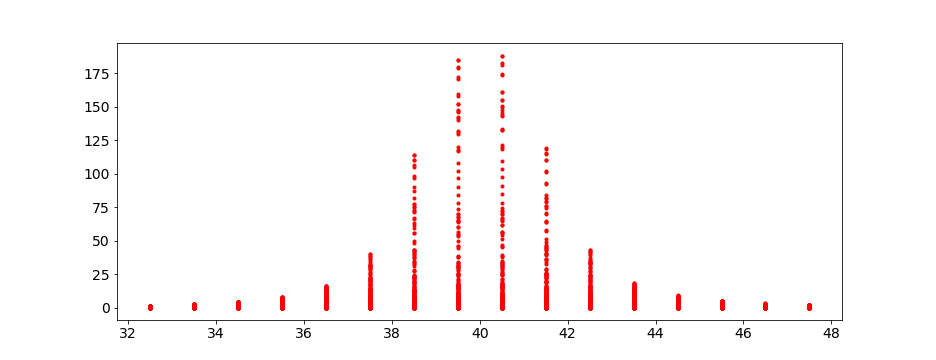

In [99]:
from graf_iono_absorp import total_input_power, MLT, input_power_scaling
from scipy.integrate import nquad

R_E = 6371e3;
Hz2Rad = 2.*np.pi
D2R = np.pi/180.
H_IONO_BOTTOM = 1e5
H_IONO_TOP = 1e6

I0 = -10000
raylats =np.unique(np.array(pairs_in_range)[:,0])
raylons =np.unique(np.array(pairs_in_range)[:,1])

print raylats, raylons

inp_pwrs = dict()

freq_pairs = zip(freqs[0:-1], freqs[1:])
lat_pairs  = zip(raylats[0:-1],raylats[1:])
lon_pairs  = zip(flash_lons[0:-1],flash_lons[1:])
print lon_pairs

flash_pos_mag = [1, flash_lat, flash_lon]
flash_pos_sm = xf.rllmag2sm(flash_pos_mag, itime)


opts = dict()
opts['epsabs']= 1.5e-8
opts['epsrel']= 1.5e-8
opts['limit']= 10

def integrand(inlat, inlon, inw):
    mlt = MLT(itime, inlon, xf);
    tmp_coords = [1, inlat, inlon];
    x_sm = xf.rllmag2sm(tmp_coords, itime);

    pwr = input_power_scaling(flash_pos_sm, x_sm, inlat, inw, I0, mlt, xf);
    return pwr*(R_E + H_IONO)*D2R*(R_E + H_IONO)*np.cos(D2R*lat)*D2R

# pwr_vec = np.zeros(len(lat_pairs))
inp_pwrs = dict()
for f1, f2 in freq_pairs:
    print f1, f2
#     n_freqs = np.ceil(np.abs(f2 - f1)/min_fstep)
    n_freqs = 1
    f_weights = (np.arange(0,1,1.0/n_freqs) + (1.0/(2.*n_freqs)))
    
    for f_weight in f_weights:
        f_center = f_weight*f1 + (1.0-f_weight)*f2
        for ind, (lat1, lat2) in enumerate(lat_pairs):
            pwr_vec = np.zeros(len(lon_pairs))
            clat = (lat1 + lat2)/2.
            w1 = Hz2Rad*f1
            w2 = Hz2Rad*f2
            w   = Hz2Rad*(f1 + f2)/2.
            dw = np.abs(f1 - f2)*Hz2Rad/n_freqs
            for lon_ind, lon_pair in enumerate(lon_pairs):                
                ranges = [[lat1, lat2], lon_pair]
        #         integ = nquad(integrand, ranges, opts=opts, full_output=False)
                integ = nquad(integrand, ranges, args=[w], opts=opts, full_output=False)
                pwr = integ[0]
                pwr_vec[lon_ind] = pwr*dw
            key = (f_center, clat)
#             print pwr_vec
            inp_pwrs[key] = pwr_vec

# ranges = [[200*Hz2Rad,30000*Hz2Rad],[0, 90], [50,105]]
# integ = nquad(integrand,ranges, opts=opts, full_output=True)

# print integ
# pwr = integ[0]
# print pwr

fig, ax = plt.subplots(1,1)
ax.plot([k[1] for k in inp_pwrs.keys()], [inp_pwrs[k] for k in inp_pwrs.keys()], 'r.')



    

t =  39
total energy:  2566.53465478


<IPython.core.display.Javascript object>


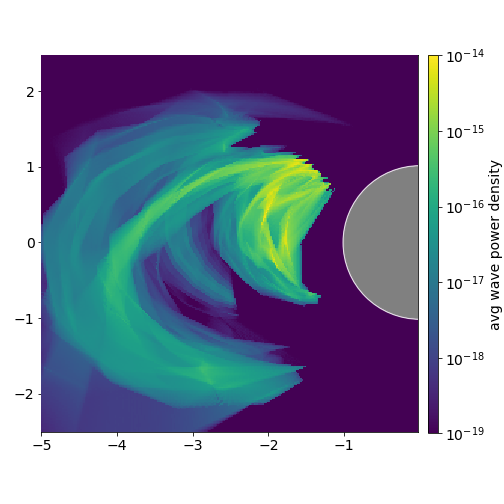

DID IT


<IPython.core.display.Javascript object>


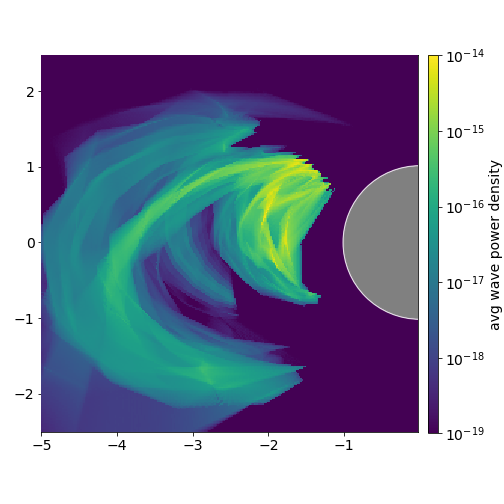

In [8]:
# Alright, there, we have a set of guide rays. The fuck do we do with it now?

xlims = [-5, 0]
ylims = [-2.5, 2.5]
zlims = [-2.5, 2.5]

step_size = 0.02
min_fstep=5000

# output space
xx = np.arange(xlims[0], xlims[1], step_size)
yy = np.arange(ylims[0], ylims[1], step_size)
zz = np.arange(zlims[0], zlims[1], step_size)

nx = len(xx) 
ny = len(yy)
nz = len(zz)

data_total = np.zeros([nx, nz])
hits = np.zeros([nx, nz])


interp_pos = dict()
interp_damp= dict()

n_freqs = 50



freq_pairs = zip(freqs[0:-1], freqs[1:])

# print inp_pwrs.keys()
for f1, f2 in freq_pairs:
#     n_freqs = np.ceil(np.abs(f2 - f1)/min_fstep)
    f_weights = (np.arange(0,1,1.0/n_freqs) + (1.0/(2.*n_freqs)))
    
    for f_weight in f_weights:
#         print f_weight
        tmax = 0
        for lat, lon in pairs_in_range:
            k1 = (f1, lat, lon)
            k2 = (f2, lat, lon)
            f_cur = f_weight*f1 + (1.0-f_weight)*f2
            k3 = (f_cur, lat, lon)
    #         print ray_data[k1]['nt'], ray_data[k2]['nt']
            tmax_local = min(np.shape(ray_data[k1]['pos'])[1], np.shape(ray_data[k2]['pos'])[1])
            newpos = f_weight*ray_data[k1]['pos'][:,0:tmax_local]  + (1.0 - f_weight)*ray_data[k2]['pos'][:,0:tmax_local]
            newdamp= f_weight*ray_data[k1]['damp'][0:tmax_local] + (1.0 - f_weight)*ray_data[k2]['damp'][0:tmax_local]
            interp_pos[k3] = newpos
            interp_damp[k3]=newdamp
#             print k1, k2, k3

lon1 = raylons[0]
lon2 = raylons[1]
# Step forward in time as the outer axis, so we can make movie frames:
# for t_ind in range(len(t)-1):
for t_ind in np.arange(39,40):
    # Per frequency
    data_cur = np.zeros([nx, nz])
    hits = np.zeros([nx, nz])

    print "t = ", t_ind
    for f1, f2 in freq_pairs:
#         n_freqs = np.ceil(np.abs(f2 - f1)/min_fstep)
        f_weights = (np.arange(0,1,1.0/n_freqs) + (1.0/(2.*n_freqs)))
#         print f1, f2
        # Per interpolated sub-frequency between guide rays:
        for f_weight in f_weights:
            f_center = f_weight*f1 + (1.0 - f_weight)*f2
            
            # Loop over adjacent sets:
            for ind, (lat1, lat2) in enumerate(lat_pairs):
                k0 = (f_center, lat1, lon1)
                k1 = (f_center, lat1, lon2)
                k2 = (f_center, lat2, lon2)
                k3 = (f_center, lat2, lon1)
                clat = (lat1 + lat2)/2.

                tmax_local = min(len(interp_damp[k0]),len(interp_damp[k1]),
                                 len(interp_damp[k2]), len(interp_damp[k3]))
                if t_ind < tmax_local - 1:
                    points = np.hstack([interp_pos[k0][:,t_ind:t_ind+2], 
                                        interp_pos[k1][:,t_ind:t_ind+2], 
                                        interp_pos[k2][:,t_ind:t_ind+2],
                                        interp_pos[k3][:,t_ind:t_ind+2]])
                    damps  = np.hstack([interp_damp[k0][t_ind:t_ind+2], 
                                        interp_damp[k1][t_ind:t_ind+2], 
                                        interp_damp[k2][t_ind:t_ind+2],
                                        interp_damp[k3][t_ind:t_ind+2]])

#                     pwr = inp_pwrs[(f_center, clat)]
                    pwr = inp_pwrs[((f1 + f2)/2., clat)]/n_freqs


#                     print t_ind, np.shape(points)
                    avgy = np.mean(points[1,:])
                    # This block for Cartesian-gridded output space:
                    minx = min(points[0,:])
                    maxx = max(points[0,:])
                    minz = min(points[2,:])
                    maxz = max(points[2,:])
                    ix = np.where((xx >= minx) & (xx <= maxx))[0]
                    iz = np.where((zz >= minz) & (zz <= maxz))[0]
                    px, pz = np.meshgrid(ix, iz, indexing='ij')  # in 3d, ij gives xyz, xy gives yxz. dumb.
                    newpoints = np.vstack([xx[px.ravel()],np.ones_like(px.ravel())*avgy, zz[pz.ravel()]])
                
                    
                    # Mean damping version:
                    damping_avg = np.mean(damps)
                    tri = Delaunay(points.T, qhull_options='QJ')
                    mask = (tri.find_simplex(newpoints.T, bruteforce=True) >= 0)*1.0
                    mask = mask.reshape([len(ix), len(iz)])
                    total_cells = np.sum(mask)
#                     print np.sum(mask > 0)
                    if (total_cells > 0):
#                         hits[mask > 0] += 1
                        voxel_vol = voxel_volume(points) # Volume in R_e
#                         print voxel_vol
                        data_cur[px,pz] += damping_avg*mask*pwr/voxel_vol/pow(R_E,3)  # better volume estimate   
#                     print voxel_volume(points)
#     data_cur[hits!=0] /= hits[hits!=0]
    print "total energy: ", np.sum(data_cur)*pow(step_size*R_E,3)
    plot_xz(data_cur, xlims,zlims,step_size)

    data_total += data_cur
        
print "DID IT"
plot_xz(data_total, xlims, zlims, step_size)
# fig, ax = plt.subplots(1,1)
# ax.pcolorfast(xx, zz, data_total.T)
# ax.set_aspect('equal')

t =  39


<IPython.core.display.Javascript object>


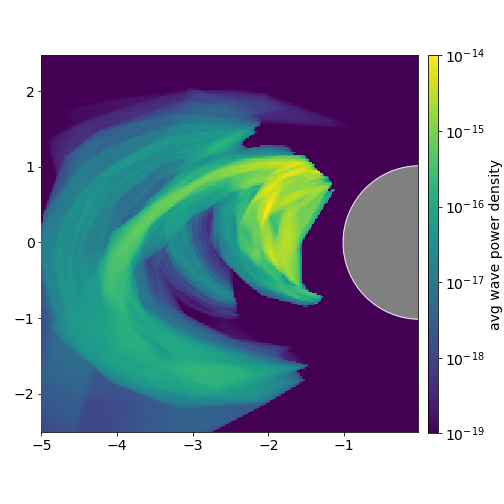

Energy:  2536.94499165
t =  40


<IPython.core.display.Javascript object>


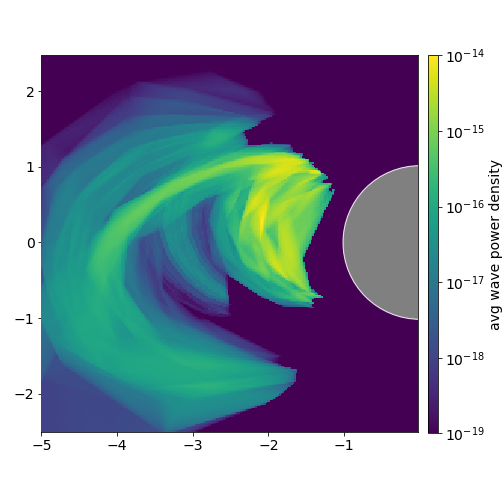

Energy:  2495.74555887
DID IT


In [25]:
# This version is the 2d-plane thing with the frequency axis on the triangulation step bit:

xlims = [-5, 0]
# ylims = [-2.5, 2.5]
zlims = [-2.5, 2.5]

step_size = 0.02
# min_fstep=5000


# output space
xx = np.arange(xlims[0], xlims[1], step_size)
zz = np.arange(zlims[0], zlims[1], step_size)
yy = np.array([0])


nx = len(xx) 
nz = len(zz)
nt = len(t)

data_total = np.zeros([nx, nz])
hits = np.zeros([nx, nz])

freq_pairs = zip(freqs[0:-1], freqs[1:])

  
# Step forward in time as the outer axis, so we can make movie frames:
# for t_ind in range(len(t)-1):
for t_ind in np.arange(39,41):
    # Per frequency
    data_cur = np.zeros([nx, nz])
#     hits = np.zeros([nx, nz])

    print "t = ", t_ind
    for f1, f2 in freq_pairs:
        # Loop over adjacent sets:
        ff = np.arange(0, 50, 1)
#         ff = np.linspace(0, 1, 10)
        nf = len(ff)

        for ind, (lat1, lat2) in enumerate(lat_pairs):
            dc = np.zeros([nx, nz, nf])
            k0 = (f1, lat1, lon1)
            k1 = (f1, lat2, lon1)
            k2 = (f2, lat1, lon1)
            k3 = (f2, lat2, lon1)
            k4 = (f1, lat1, lon2)
            k5 = (f1, lat2, lon2)
            k6 = (f2, lat1, lon2)
            k7 = (f2, lat2, lon2)
            clat = (lat1 + lat2)/2.
            f_center = (f1 + f2)/2.

            tmax_local = min(np.shape(ray_data[k0]['pos'])[1], np.shape(ray_data[k1]['pos'])[1],
                             np.shape(ray_data[k2]['pos'])[1], np.shape(ray_data[k3]['pos'])[1],
                             np.shape(ray_data[k4]['pos'])[1], np.shape(ray_data[k5]['pos'])[1],
                             np.shape(ray_data[k6]['pos'])[1], np.shape(ray_data[k7]['pos'])[1])
#             print clat, tmax_local
            if (t_ind < tmax_local - 1):

                points_4d = np.hstack([np.vstack([ray_data[k0]['pos'][:,t_ind:t_ind+2],np.zeros([1,2])]),
                                       np.vstack([ray_data[k1]['pos'][:,t_ind:t_ind+2],np.zeros([1,2])]),
                                       np.vstack([ray_data[k2]['pos'][:,t_ind:t_ind+2],np.ones([1,2])*nf]),
                                       np.vstack([ray_data[k3]['pos'][:,t_ind:t_ind+2],np.ones([1,2])*nf]),
                                       np.vstack([ray_data[k4]['pos'][:,t_ind:t_ind+2],np.zeros([1,2])]),
                                       np.vstack([ray_data[k5]['pos'][:,t_ind:t_ind+2],np.zeros([1,2])]),
                                       np.vstack([ray_data[k6]['pos'][:,t_ind:t_ind+2],np.ones([1,2])*nf]),
                                       np.vstack([ray_data[k7]['pos'][:,t_ind:t_ind+2],np.ones([1,2])*nf])])
#                 tri = Delaunay(points_4d.T, qhull_options='QJ')
                voxel_vol = voxel_vol_nd(points_4d)*pow(R_E,3.)

                points_2d = np.hstack([np.vstack([ray_data[k4]['pos'][[0,2],t_ind:t_ind+2], np.zeros([1,2])]),
                                       np.vstack([ray_data[k5]['pos'][[0,2],t_ind:t_ind+2], np.zeros([1,2])]),
                                       np.vstack([ray_data[k6]['pos'][[0,2],t_ind:t_ind+2], np.ones([1,2])*nf]),
                                       np.vstack([ray_data[k7]['pos'][[0,2],t_ind:t_ind+2], np.ones([1,2])*nf])])

                damps_2d = np.hstack([ray_data[k0]['damp'][t_ind:t_ind+2],
                                      ray_data[k1]['damp'][t_ind:t_ind+2],
                                      ray_data[k2]['damp'][t_ind:t_ind+2],
                                      ray_data[k3]['damp'][t_ind:t_ind+2]])

                damping_avg = np.mean(damps_2d)
#                 print damping_avg
                pwr = inp_pwrs[(f_center, clat)]  # Avg pwr per frequency bin
#                 print pwr
                minx = min(points_2d[0,:])
                maxx = max(points_2d[0,:])
#                 miny = min(points_2d[1,:])
#                 maxy = max(points_2d[1,:])
                minz = min(points_2d[1,:])
                maxz = max(points_2d[1,:])
                ix = np.where((xx >= minx) & (xx <= maxx))[0]
#                 iy = np.where((yy >= miny) & (yy <= maxy))[0]
                iz = np.where((zz >= minz) & (zz <= maxz))[0]
#                 print iy
                ief= np.arange(0, nf)
                px, pz, pf = np.meshgrid(ix, iz, ief, indexing='ij')  # in 3d, ij gives xyz, xy gives yxz. dumb.
                newpoints = np.vstack([xx[px.ravel()], zz[pz.ravel()], ff[pf.ravel()]])

                tri = Delaunay(points_2d.T, qhull_options='QJ')
                mask = (tri.find_simplex(newpoints.T) >= 0)*1.0
#                 mask = np.zeros(len(maskvals))
#                 mask[maskvals >= 0] = 1.0
                mask = mask.reshape([len(ix), len(iz), len(ief)])
                total_cells = np.sum(mask)
#                 print total_cells
                if (total_cells > 0):
#                     print np.shape(weight_vect), np.shape(dc), np.shape(mask)
                    # using total_cells assures all energy is accounted for, but
                    # does NOT account for spreading in longitude.
#                     dc[px,pz,pf] = mask/total_cells/pow(step_size*R_E,3)     
#                     dc[px,pz,pf] = damping_avg*pwr*mask/voxel_vol/nf/pow(R_E,3)     
                    dc[px,pz,pf] = damping_avg*pwr*mask/voxel_vol


#                     dc[px, pz, pf] = mask/voxel_vol/pow(step_size*R_E,3)

#                     dc[px,pz,pf] += mask*1.0
#                     print np.sum(dc)
                    data_cur += np.sum(dc,axis=-1)

    plot_xz(data_cur, xlims,zlims,step_size)
    
    data_total += data_cur     
    print "Energy: ", np.sum(np.sum(data_cur))*pow(step_size*R_E,3)

   
    data_total += data_cur
        
print "DID IT"


In [8]:
import math
def voxel_vol_nd(points, tri=None):
    n, m = np.shape(points)
#     print n
#     print k
    if tri is None:
        tri = Delaunay(points.T, qhull_options='QJ')
    v = 0
    for row in tri.simplices:
        
        mat = points[:, row[1:]].T - points[:, row[0]].T
        v += np.abs(np.linalg.det(mat)/math.factorial(n))
#         print "new way:", np.abs(np.linalg.det(mat)/math.factorial(n))
        

        
#         a = points[:,row[0]]
#         b = points[:,row[1]]
#         c = points[:,row[2]]
#         d = points[:,row[3]]
        
#         print "old way:", np.abs( np.dot(a - d, np.cross(b-d, c-d)))/6.
    return v
# voxel_vol_nd(points_3d)

In [152]:
print "total energy:",np.sum(inp_pwrs.values())
np.shape(inp_pwrs.keys())



total energy: 9116.53249513


(832, 2)

In [24]:
print points_4d.T

[[ -7.89015617e-01   6.88563498e-03   8.46147879e-01   0.00000000e+00]
 [ -1.85448159e+00   1.61838157e-02   5.70033588e-01   0.00000000e+00]
 [ -7.74128692e-01   6.75571875e-03   8.59789752e-01   0.00000000e+00]
 [ -1.86157340e+00   1.62457050e-02   5.62174869e-01   0.00000000e+00]
 [ -7.89015617e-01   6.88563498e-03   8.46147879e-01   5.00000000e+01]
 [ -1.88168378e+00   1.64212055e-02   5.70234745e-01   5.00000000e+01]
 [ -7.74128692e-01   6.75571875e-03   8.59789752e-01   5.00000000e+01]
 [ -1.89430084e+00   1.65313130e-02   5.80763423e-01   5.00000000e+01]
 [ -7.89015617e-01  -6.88563498e-03   8.46147879e-01   0.00000000e+00]
 [ -1.85448159e+00  -1.61838157e-02   5.70033588e-01   0.00000000e+00]
 [ -7.74128692e-01  -6.75571875e-03   8.59789752e-01   0.00000000e+00]
 [ -1.86157340e+00  -1.62457050e-02   5.62174869e-01   0.00000000e+00]
 [ -7.89015617e-01  -6.88563498e-03   8.46147879e-01   5.00000000e+01]
 [ -1.88168378e+00  -1.64212055e-02   5.70234745e-01   5.00000000e+01]
 [ -7.

<IPython.core.display.Javascript object>


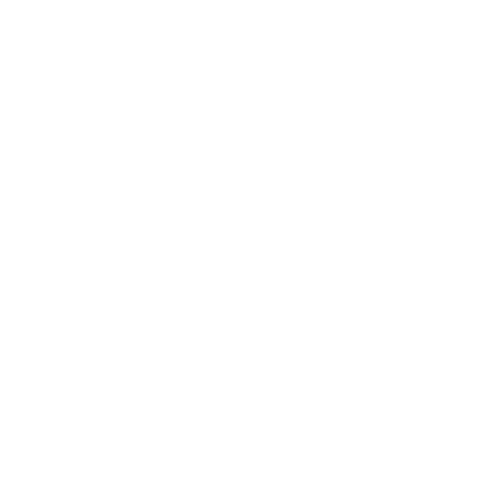

(122, 50)


IndexError: too many indices for array

In [85]:
fig, ax = plt.subplots(1,10)
print np.shape(mask)
for i in range(10):
    ax[i].imshow(mask[:,:,i], origin='lower',interpolation='None')
    ax[i].set_aspect('equal')

<IPython.core.display.Javascript object>


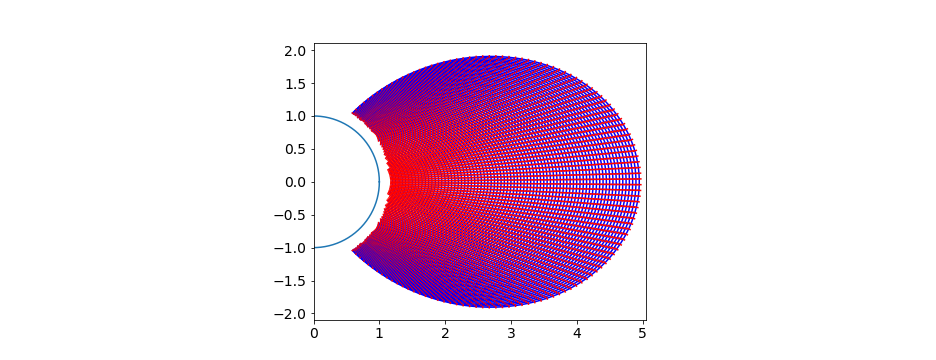

In [185]:
# Similar deal, but now let's look along field lines instead of a Cartesian grid

# Target L-shells:
L_step = 0.05
Lshells = np.arange(1.2, 5, L_step) #[1.5, 2, 2.5, 3]
# n_lsteps = 100
dlat= 1.0 # degree
L_MARGIN = L_step/2.0
R2D = 180./np.pi
D2R = np.pi/180.

# ------------------ Set up field lines ----------------------------
fieldlines = []
for L in Lshells:
    
    fieldline = dict()
    
    maxlat = np.floor(np.arccos(np.sqrt((R_E + H_IONO_TOP)/R_E/L))*R2D)
    n_lsteps = int(np.round(2.0*maxlat/dlat))
    lat_divisions = np.linspace(maxlat, -1.0*maxlat, n_lsteps+1)
    lat_centers   = lat_divisions[0:-1] - dlat/2.
#     print np.shape(lat_centers)
    fieldline['lat'] = lat_centers
    
    # Radius of tube around field line:
    clam = np.sin(lat_centers*D2R)
    slam = np.cos(lat_centers*D2R)
    clam2 = pow(clam,2.)
    slam2 = pow(slam,2.)
    rootTerm = np.sqrt(1.0*3.0*slam2)
   
    clam = np.cos(lat_centers*D2R);
    slam = np.sin(lat_centers*D2R);
    clam2 = pow(clam,2);
    slam2 = pow(slam,2);
    rootTerm = np.sqrt(1+3*slam2);

    radii = clam2*clam / rootTerm * L_MARGIN
    R_centers = L*clam2
    
    fieldline['R'] = R_centers
    fieldline['xradius']= radii
    
    # Approximate each segment as a cylinder:
    seg_length = R_centers*dlat*D2R
    seg_vol = np.pi*pow(radii,2.)*seg_length*pow(R_E,3.)  # cubic meters

    fieldline['vol'] = seg_vol
    fieldline['total_vol'] = np.sum(seg_vol)

    fieldline['x'] = R_centers*clam
    fieldline['y'] = R_centers*slam
    
    fieldline['x_unit_vect'] = (3*clam2 - 2) / rootTerm ;
    fieldline['y_unit_vect'] = (3*slam*clam) / rootTerm ;


    
    coords_rllmag = np.vstack([R_centers, lat_centers, np.ones(len(lat_centers))*flash_lon])
    coords_sm = []
    for row in coords_rllmag.T:
        coords_sm.append(xf.rllmag2sm(row, itime))

    
    fieldline['pos'] = np.array(coords_sm)
    fieldlines.append(fieldline)


#     print fieldline['pos']
    
#     print np.array(coords_sm)

#    ## Pretty plot stuff
fig, ax = plt.subplots(1,1)
for fl in fieldlines:

    pX = fl['x'] #-1.0*fl['pos'][:,0] #fl['x']
    pY = fl['y'] #fl['pos'][:,2] #fl['y']

    x1 = pX - fl['x_unit_vect']*fl['xradius']
    x2 = pX + fl['x_unit_vect']*fl['xradius']

    y1 = pY - fl['y_unit_vect']*fl['xradius']
    y2 = pY + fl['y_unit_vect']*fl['xradius']

    
    ax.plot(pX, pY,'b')
    ax.plot([x1, x2], [y1,y2], 'r')

ll = np.linspace(0, 2*np.pi,100)
ax.plot(np.cos(ll), np.sin(ll))
ax.set_xlim([0,max(Lshells)+2*L_step])
ax.set_aspect('equal')


In [120]:
# This version is the 2d-plane thing with the frequency axis on the triangulation step bit:

# output space
nfl = len(fieldlines)
nlons = len(flash_lons) - 1
data_total = np.zeros([nfl, nlons, nt])

freq_pairs = zip(freqs[0:-1], freqs[1:])
n_sub_freqs = 50
lon1 = raylons[0]
lon2 = raylons[1]

# Step forward in time as the outer axis, so we can make movie frames:
for t_ind in np.arange(nt - 1):
    # Per frequency
    data_cur = np.zeros(nfl)
    print "t = ", t_ind
    for f1, f2 in freq_pairs:
        # Loop over adjacent sets:
        ff = np.arange(0, n_sub_freqs, 1)
        nf = len(ff)

        for lat1, lat2 in lat_pairs:
            dc = np.zeros([nx, nz, nf])
            k0 = (f1, lat1, lon1)
            k1 = (f1, lat2, lon1)
            k2 = (f2, lat1, lon1)
            k3 = (f2, lat2, lon1)
            k4 = (f1, lat1, lon2)
            k5 = (f1, lat2, lon2)
            k6 = (f2, lat1, lon2)
            k7 = (f2, lat2, lon2)
            clat = (lat1 + lat2)/2.
            f_center = (f1 + f2)/2.

            tmax_local = min(np.shape(ray_data[k0]['pos'])[1], np.shape(ray_data[k1]['pos'])[1],
                             np.shape(ray_data[k2]['pos'])[1], np.shape(ray_data[k3]['pos'])[1],
                             np.shape(ray_data[k4]['pos'])[1], np.shape(ray_data[k5]['pos'])[1],
                             np.shape(ray_data[k6]['pos'])[1], np.shape(ray_data[k7]['pos'])[1])
#             print clat, tmax_local
            if (t_ind < tmax_local - 1):

                points_4d = np.hstack([np.vstack([ray_data[k0]['pos'][:,t_ind:t_ind+2],np.zeros([1,2])]),
                                       np.vstack([ray_data[k1]['pos'][:,t_ind:t_ind+2],np.zeros([1,2])]),
                                       np.vstack([ray_data[k2]['pos'][:,t_ind:t_ind+2],np.ones([1,2])*nf]),
                                       np.vstack([ray_data[k3]['pos'][:,t_ind:t_ind+2],np.ones([1,2])*nf]),
                                       np.vstack([ray_data[k4]['pos'][:,t_ind:t_ind+2],np.zeros([1,2])]),
                                       np.vstack([ray_data[k5]['pos'][:,t_ind:t_ind+2],np.zeros([1,2])]),
                                       np.vstack([ray_data[k6]['pos'][:,t_ind:t_ind+2],np.ones([1,2])*nf]),
                                       np.vstack([ray_data[k7]['pos'][:,t_ind:t_ind+2],np.ones([1,2])*nf])])
            
                voxel_vol = voxel_vol_nd(points_4d)*pow(R_E,3.)

                damps_2d = np.hstack([ray_data[k0]['damp'][t_ind:t_ind+2],
                                      ray_data[k1]['damp'][t_ind:t_ind+2],
                                      ray_data[k2]['damp'][t_ind:t_ind+2],
                                      ray_data[k3]['damp'][t_ind:t_ind+2]])
                damping_avg = np.mean(damps_2d)
                
                pwr = inp_pwrs[(f_center, clat)]  # Avg pwrs per frequency bin
                
                points_2d = np.hstack([np.vstack([ray_data[k4]['pos'][[0,2],t_ind:t_ind+2], np.zeros([1,2])]),
                                       np.vstack([ray_data[k5]['pos'][[0,2],t_ind:t_ind+2], np.zeros([1,2])]),
                                       np.vstack([ray_data[k6]['pos'][[0,2],t_ind:t_ind+2], np.ones([1,2])*nf]),
                                       np.vstack([ray_data[k7]['pos'][[0,2],t_ind:t_ind+2], np.ones([1,2])*nf])])
                tri = Delaunay(points_2d.T, qhull_options='QJ')
#                 tri = Delaunay(points_4d.T, qhull_options='QJ')
                
                for fl_ind, fl in enumerate(fieldlines):
                    ix = np.arange(0,len(fl['pos']))
                    ief= np.arange(0, nf)    
                    px, pf = np.meshgrid(ix, ief, indexing='ij')  # in 3d, ij gives xyz, xy gives yxz. dumb.
                    newpoints = np.hstack([fl['pos'][px.ravel(),:][:,[0,2]], np.atleast_2d(ff[pf.ravel()]).T])

                    mask = (tri.find_simplex(newpoints) >= 0)*1.0
                    mask = mask.reshape([len(ix), len(ief)])
                    
                    total_cells = np.sum(mask)
                    if (total_cells > 0):
                        data_total[fl_ind, :, t_ind] += (damping_avg*pwr/voxel_vol)* \
                                        np.sum(mask*fl['vol'][:,np.newaxis])/fl['total_vol']
                    
    print "Energy: ", np.sum(data_total[:, :, t_ind], axis=0)
#     data_total += data_cur
        
print "DID IT"


t =  0
Energy:  [  1.14747628e-14   9.03440952e-15   5.05639145e-15   2.91657651e-15
   1.81701514e-15   1.20362894e-15   8.31973670e-16   5.89762570e-16
   4.20830088e-16   2.95290402e-16]
t =  1
Energy:  [  1.58950178e-14   1.24918102e-14   6.99927038e-15   4.03965319e-15
   2.51728001e-15   1.66783611e-15   1.15326692e-15   8.18121576e-16
   5.84610000e-16   4.11287813e-16]
t =  2
Energy:  [  1.66292309e-14   1.30308841e-14   7.27070827e-15   4.17495692e-15
   2.58943468e-15   1.70939771e-15   1.17920480e-15   8.35814617e-16
   5.97975335e-16   4.22480903e-16]
t =  3
Energy:  [  1.23009795e-14   9.68204136e-15   5.38899732e-15   3.09038364e-15
   1.91658169e-15   1.26617131e-15   8.74968128e-16   6.22267942e-16
   4.48008736e-16   3.20135777e-16]
t =  4
Energy:  [  7.04156366e-15   5.55652816e-15   3.12131178e-15   1.80896686e-15
   1.13318178e-15   7.55678461e-16   5.27052918e-16   3.78633292e-16
   2.76032106e-16   2.00710760e-16]
t =  5
Energy:  [  5.52604740e-15   4.35485268e-15

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


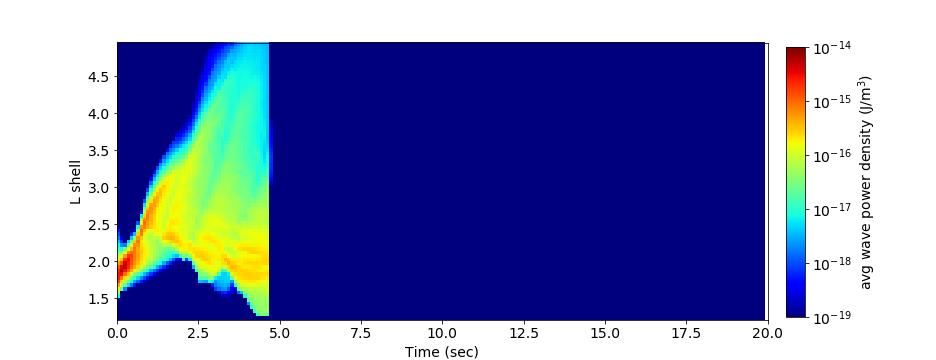

(76, 10, 200)


In [194]:
# Plot energy density per L-shell vs time:
def plot_LT(data, tlims, dt, Llims, dl, clims=None):
    
    nL, nLons, nt = np.shape(data)
    
    Lvec = np.arange(Llims[0], Llims[1], dl)
    tvec = np.arange(0, nt, 1)*dt
    
    fig, ax = plt.subplots(1,1)
    logdata = np.log10(data[:,0,:])
    logdata[np.isinf(logdata)] = -100

    if clims is None:
        maxval = np.ceil(np.max(logdata))
        clims = [maxval - 5, maxval]
    
    print np.shape(data)
    p0 = ax.pcolorfast(tvec, Lvec, logdata, vmin=clims[0], vmax=clims[1], cmap=plt.get_cmap('jet'))

    fig.subplots_adjust(right=0.82)
    cax = fig.add_axes([0.84,0.12, 0.02, 0.75])

    cb = plt.colorbar(p0, cax=cax)
    cb.set_label('avg wave power density (J/m$^3$)')
    cticks = np.arange(clims[0],clims[1] + 1)
    cb.set_ticks(cticks)
    cticklabels = ['$10^{%d}$'%k for k in cticks]
    cb.set_ticklabels(cticklabels)



    ax.set_ylabel('L shell')
    ax.set_xlabel('Time (sec)')
    ax.set_xlim(tlims)
    
plot_LT(data_total,[0, 20],dt, [1.2, 5], L_step)

<IPython.core.display.Javascript object>


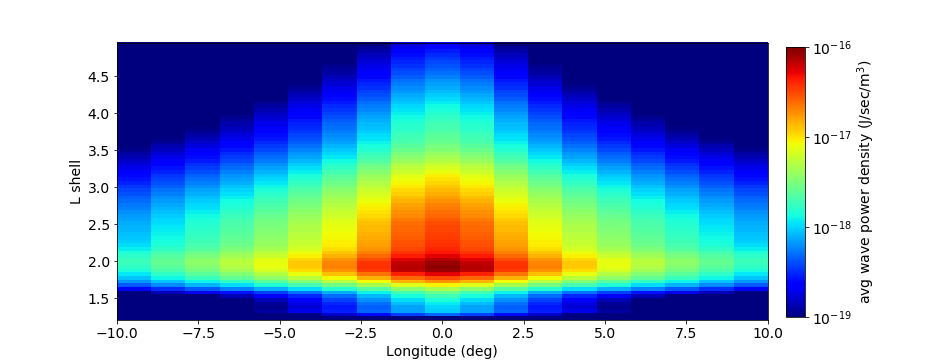

In [195]:
# 2d plot, longitude vs L-shell:
# def plot_lon_L(data, lonlims, dlon, Llims, dl, clims=None):
logdata = np.log10(np.sum(data_total, axis=-1)*dt/tmax)
logdata[np.isinf(logdata)] = -1000

logdata = np.vstack([np.flipud(logdata[:,1:].T), logdata.T]).T


maxval = np.ceil(np.max(logdata))

clims = [maxval - 3, maxval]

fig, ax = plt.subplots(1,1)
xaxis = np.concatenate([-1.*d_lon*num_lons + flash_lons[0:-1], flash_lons]) - flash_lon
p0 = ax.pcolorfast(xaxis, Lshells, logdata, vmin=clims[0], vmax=clims[1], cmap=plt.get_cmap('jet'))

fig.subplots_adjust(right=0.82)
cax = fig.add_axes([0.84,0.12, 0.02, 0.75])

cb = plt.colorbar(p0, cax=cax)
cb.set_label('avg wave power density (J/sec/m$^3$)')
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)

ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('L shell')



In [181]:
# tmp = np.sum((damping_avg/voxel_vol)*mask*fl['vol'][:,np.newaxis])/fl['total_vol']
# print tmp*pwr
# print np.shape(pwr)
# print np.shape(Lshells)
# print np.shape(data_total)

print tmax

20
